In [3]:
%matplotlib notebook
%matplotlib inline

Installation of necessary package for collab to run it

In [4]:
!pip install desdeo_emo
!pip install desdeo_problem
!pip install pygmo
!pip install pyDOE

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.1/68.1 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 35.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 73.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.1/167.1 kB 16.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18167 sha256=f92b28a9c4bee33f2ad03eed807232cae8057bbbbfbaef105442e91a91c47932
  Stored in directory: /root/.cache/pip/wheels/ce/b6

Import necessary libraries

In [5]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from desdeo_problem import DataProblem
from desdeo_problem.surrogatemodels.SurrogateModels import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from desdeo_problem.surrogatemodels.lipschitzian import LipschitzianRegressor
from desdeo_problem.testproblems.TestProblems import test_problem_builder
from pyDOE import lhs
from desdeo_emo.EAs.RVEA import RVEA
from desdeo_emo.EAs.NSGAIII import NSGAIII
import plotly.express as px
from desdeo_problem import variable_builder, ScalarObjective, MOProblem, VectorObjective, ScalarConstraint
from desdeo_emo.EAs import NSGAIII
from sklearn.preprocessing import MinMaxScaler
from pygmo import non_dominated_front_2d as nd2


Building the problem and evaluating on the created data-set

In [9]:

problem_name = "bike"
training_data = pd.read_csv("./output.csv", comment="#")
data1 = np.asarray(training_data)
data = data1[:, 1:6]  # Exclude the first column since it is not needed
value1=(max(data[:,4])+min(data[:,4]))/2

var_names = ["A", "S", "B","L", "D"]  

initial_values = [15, 15,  15,  15, min(data[:,4])+1]
lower_bounds = [14, 14, 14, 14,min(data[:,4])]
upper_bounds = [50, 50, 50, 50,max(data[:,4])]

variables = variable_builder(var_names, initial_values, lower_bounds, upper_bounds)
print("Type of \"variables\": ", type(variables))
print("Length of \"variables\": ", len(variables))
print("Type of the contents of \"variables\": ", type(variables[0]))


def obj1(x): 
    y1 = (x[:, 0] + x[:, 1] + x[:, 2] + x[:, 3])/4
    return y1


def obj2(x): 
    y2 = x[:, 4]
    return y2

f1 = ScalarObjective(name='y1', evaluator=obj1, maximize=True)
f2 = ScalarObjective(name='y2', evaluator=obj2)
list_objs = [f1, f2]


const_func = lambda x, y: -17 +( x[:, 0] + x[:,1] + x[:, 2] + x[:, 3])/4
const_func2 = lambda x, y: value1 - (x[:, 4])

cons1 = ScalarConstraint("c_1", 5, 2, const_func)
cons2 = ScalarConstraint("c_2", 5, 2, const_func2)

prob = MOProblem(objectives=[f1, f2], variables=variables, constraints=[cons1,cons2])

y = prob.evaluate(data)

Type of "variables":  <class 'list'>
Length of "variables":  5
Type of the contents of "variables":  <class 'desdeo_problem.problem.Variable.Variable'>


/usr/local/lib/python3.10/dist-packages/desdeo_problem/problem/Problem.py:1158: UserWarning:

Some decision variable values violate lower bounds



Non dominated front obtained

In [10]:
##
# def find_non_dominated_front(objectives):
#     num_points = len(objectives)
#     dominates = [0] * num_points
#     dominated_by = [[] for _ in range(num_points)]
    
#     for i in range(num_points):
#         for j in range(i + 1, num_points):
#             if all(objectives[i][k] <= objectives[j][k] for k in range(len(objectives[i]))):
#                 if any(objectives[i][k] < objectives[j][k] for k in range(len(objectives[i]))):
#                     dominates[i] += 1
#                     dominated_by[j].append(i)
#             elif all(objectives[j][k] <= objectives[i][k] for k in range(len(objectives[i]))):
#                 if any(objectives[j][k] < objectives[i][k] for k in range(len(objectives[i]))):
#                     dominates[j] += 1
#                     dominated_by[i].append(j)
    
#     non_dominated_front = []
#     for i in range(num_points):
#         if dominates[i] == 0:
#             non_dominated_front.append(i)
    
#     return non_dominated_front

# data_pareto = find_non_dominated_front(y.objectives)
# pareto_front = [y.objectives[i] for i in data_pareto]
##

data_pareto = nd2(y.objectives)
y.objectives[data_pareto]

array([[ 20.25, 988.  ],
       [ 20.75, 929.  ],
       [ 21.25, 924.  ],
       [ 21.75, 865.  ],
       [ 23.25, 736.  ]])

Creat the DataProblem class with dataframe and objectives to be maximized or minimized

In [11]:
new_column_data = 10*(training_data[" A"]+training_data[" S"]+training_data[" B"]+training_data[" L"])/4 
training_data["AVG"] = new_column_data
maximize = pd.DataFrame([[False, True]], columns=[' D','AVG'])
problem = DataProblem(data=training_data, variable_names=[' A',' S',' B',' L'], objective_names=[' D','AVG'], maximize=maximize)

Train problem object with Lipschitzian Regressor for optimistic and robust selection 

In [12]:
problem.train(LipschitzianRegressor)
    
evolver_L = NSGAIII(problem, use_surrogates=True) #optimistic
while evolver_L.continue_evolution():
    evolver_L.iterate()
    
evolver_L_robust = NSGAIII(problem, use_surrogates=True, selection_type="robust") #robust
while evolver_L_robust.continue_evolution():
    evolver_L_robust.iterate()

Train problem object with Gaussian Process Regressor for optimistic and robust selection 

In [13]:
problem.train(GaussianProcessRegressor, {"kernel": Matern(nu=3/2)})
evolver_G_opt = NSGAIII(problem, use_surrogates=True, selection_type="optimistic") #optimistic
while evolver_G_opt.continue_evolution():
    evolver_G_opt.iterate()
    
evolver_G_robust = NSGAIII(problem, use_surrogates=True, selection_type="robust") #robust
while evolver_G_robust.continue_evolution():
    evolver_G_robust.iterate()

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but GaussianProcessRegressor was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but GaussianProcessRegressor was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but GaussianProcessRegressor was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but GaussianProcessRegressor was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but GaussianProcessRegressor was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not hav

Visualization of Pareto Fronts with all training and selection methods

In [14]:
front_L = evolver_L.population.objectives
front_G_opt = evolver_G_opt.population.objectives - evolver_G_opt.population.uncertainity
front_L_robust = evolver_L_robust.population.objectives + evolver_L_robust.population.uncertainity
front_G_robust = evolver_G_robust.population.objectives + evolver_G_robust.population.uncertainity

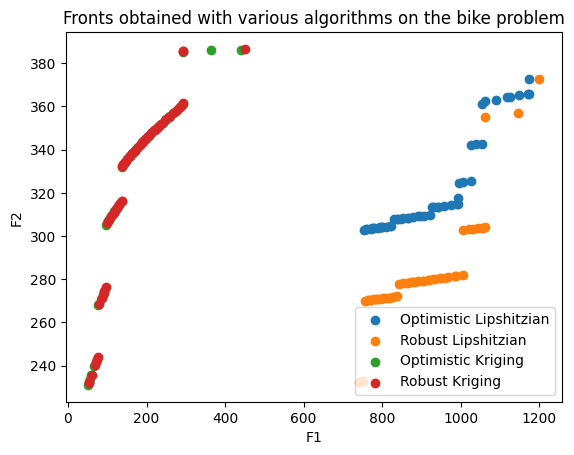

In [15]:
L = plt.scatter(x=front_L[:,0], y=front_L[:,1], label="Optimistic Lipshitzian")
L_robust = plt.scatter(x=front_L_robust[:,0], y=front_L_robust[:,1], label="Robust Lipshitzian")
G_opt = plt.scatter(x=front_G_opt[:,0], y=front_G_opt[:,1], label="Optimistic Kriging")
G_robust = plt.scatter(x=front_G_robust[:,0], y=front_G_robust[:,1], label="Robust Kriging")
plt.title(f"Fronts obtained with various algorithms on the {problem_name} problem")
plt.xlabel("F1")
plt.ylabel("F2")
plt.legend()

plt.show()

Visualization of our Dataset and its Pareto front

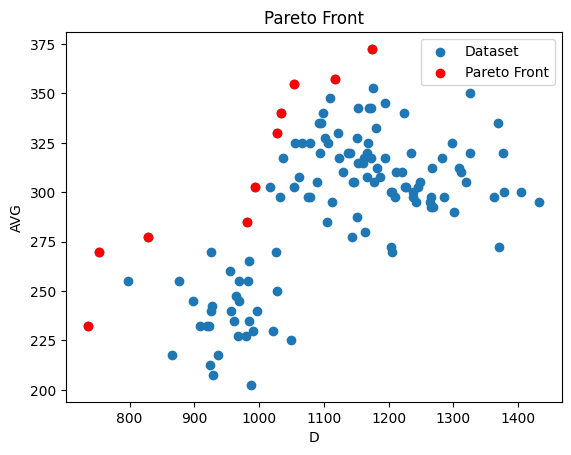

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the dataset
data = {
    'D': list(training_data[' D']),
    'AVG': list(training_data['AVG'])
}

# Create a DataFrame from the dataset
df = pd.DataFrame(data)
pareto_front = []


for i, point in df.iterrows():
    d = point['D']
    avg = point['AVG']
    
    is_dominated = False
    for j, other_point in df.iterrows():
        other_d = other_point['D']
        other_avg = other_point['AVG']
        
        if (other_d < d and other_avg >= avg) or (other_d <= d and other_avg > avg):
            is_dominated = True
            break
    
    if not is_dominated:
        pareto_front.append((d, avg))


pareto_d = [point[0] for point in pareto_front]
pareto_avg = [point[1] for point in pareto_front]

# Plot the Pareto front
plt.scatter(df['D'], df['AVG'], label='Dataset')
plt.scatter(pareto_d, pareto_avg, color='red', label='Pareto Front')
plt.xlabel('D')
plt.ylabel('AVG')
plt.title('Pareto Front')
plt.legend()
plt.show()